In [12]:
# include("/home/anooja/Dropbox/anooja/EMPA/BG_periodic_potential_Jian/Goncalo_TB/2by2/code/MyPyPlots.jl")
include("/home/anooja/Dropbox/anooja/EMPA/BG_periodic_potential_Jian/Goncalo_TB/code_2/MyPlots.jl")
include("/home/anooja/Dropbox/anooja/EMPA/BG_periodic_potential_Jian/Goncalo_TB/code_2/AuxFunctions.jl")
include("/home/anooja/Dropbox/anooja/EMPA/BG_periodic_potential_Jian/Goncalo_TB/code_2/Hamiltonians.jl")
# import .MyPyPlots
import .MyPlots
import .AuxFunctions
import .Hamiltonians

using DelimitedFiles
using LinearAlgebra

In [ ]:
using Pkg
Pkg.add("PyCall")
using PyCall
np = pyimport("numpy")

In [ ]:
Pkg.add("Arpack")
Pkg.add("PyPlot")
Pkg.add("Plots")

In [13]:
"""
phi-path corresponding to k-path Γ -> K -> M -> Γ of 2D hexagonal lattice
    assuming a1 = [1,0]*a, a2 = [-1/2,sqrt(3)/2]*a

GC, 08-03-2024
"""
function phipath_2D_GammaKMGamma(;Npiover3=10)
    # dphi
    dphi = (pi/3)/Npiover3

    # initialize phi-path
    phi1path = Float64[]
    phi2path = Float64[]

    # phi-path points
    Gamma = [0.0, 0.0]
    K = [-2*pi/3, -2*pi/3]
    M = [0.0, -pi]

    #Gamma -> K
    GammaK_phi1 = [phi1 for phi1 in Gamma[1]:-dphi:K[1]+1e-8]
    GammaK_phi2 = [phi2 for phi2 in Gamma[2]:-dphi:K[2]+1e-8]
    append!(phi1path,GammaK_phi1)
    append!(phi2path,GammaK_phi2)

    #K -> M
    KM_phi1 = [phi1 for phi1 in K[1]:2*dphi:M[1]-1e-8]
    KM_phi2 = [phi2 for phi2 in K[2]:-dphi:M[2]+1e-8]
    append!(phi1path,KM_phi1)
    append!(phi2path,KM_phi2)

    #M -> Gamma
    npts = round(sqrt(3)/2*length(GammaK_phi1))
    dphiaux = (Gamma[2]-M[2])/npts
    MGamma_phi2 = [phi2 for phi2 in M[2]:dphiaux:Gamma[2]-1e-8]
    MGamma_phi1 = [0.0 for it in 1:length(MGamma_phi2)]
    append!(phi1path,MGamma_phi1)
    append!(phi2path,MGamma_phi2)

    # include last point
    append!(phi1path,Gamma[1])
    append!(phi2path,Gamma[2])

    # phi-path
    phipath = hcat(phi1path,phi2path)

    # path ticks
    pathtickpos = [1,
        1+size(GammaK_phi1,1),
        1+size(GammaK_phi1,1)+size(KM_phi1,1),
        size(phi1path,1)]
    pathticklabels = ["Γ","K","M","Γ"]
    pathticks = (pathtickpos,pathticklabels)

    return phipath,pathticks
end
;

# Import sites and vectors

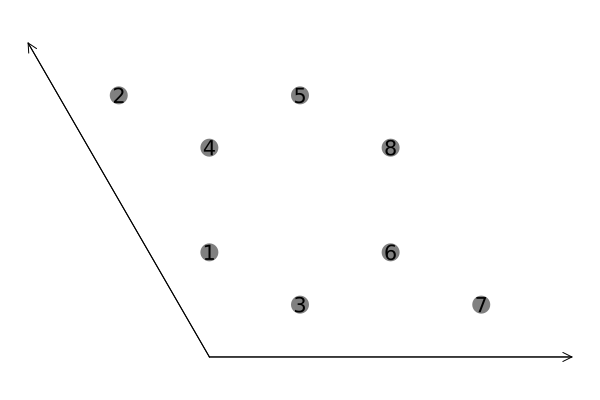

In [15]:
sites_path = "sites.txt"

dCC = 1.42028 #angstrom
uc = readdlm(sites_path, skipstart=1) #angstrom
a1 = [4.9200000763,         0.0000000000,         0.0000000000] #angstrom
a2 = [-2.4600000381,        4.2608450527,         0.0000000000] #angstrom

MyPlots.structures2D(uc,vecs=[a1,a2],sitelabels=true)

# Find neighbors

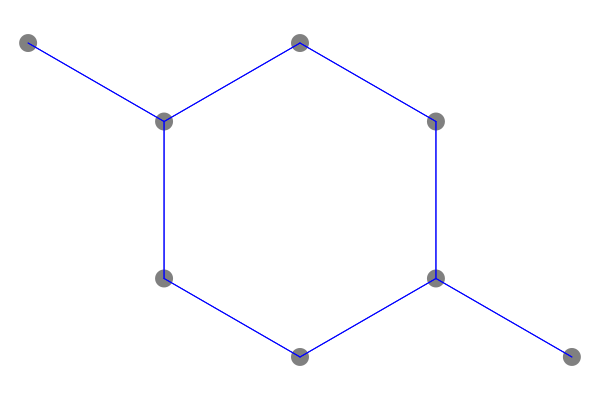

In [16]:
neighbors_uc,neighbors_n1n2 = AuxFunctions.neighbors_honeycomb_2DBloch(uc,a1,a2,dNN=dCC,tol=1e-5*dCC);

MyPlots.structures2D(uc,neighbors=neighbors_uc,linecolors=["blue"])

# Hamiltonian

In [17]:
t1 = -2.7 #eV

H2D(phi1,phi2) = Hamiltonians.TB_Bloch2D(phi1,phi2,neighbors_uc,neighbors_n1n2,hoppings=[t1])

H2D (generic function with 1 method)

In [ ]:
# ktest = [0.2,0.1,0] #Angstrom^(-1)
ktest = [0.0167,0.0167,0] #Angstrom^(-1)

phi1 = dot(ktest,a1)
phi2 = dot(ktest,a2)

result_array= H2D(phi1,phi2)
np_result_array = np.array(result_array)
ishermitian(H2D(phi1,phi2))
filepath = "Hk_[0.0167,0.0167,0].dat"
writedlm(filepath, np_result_array)

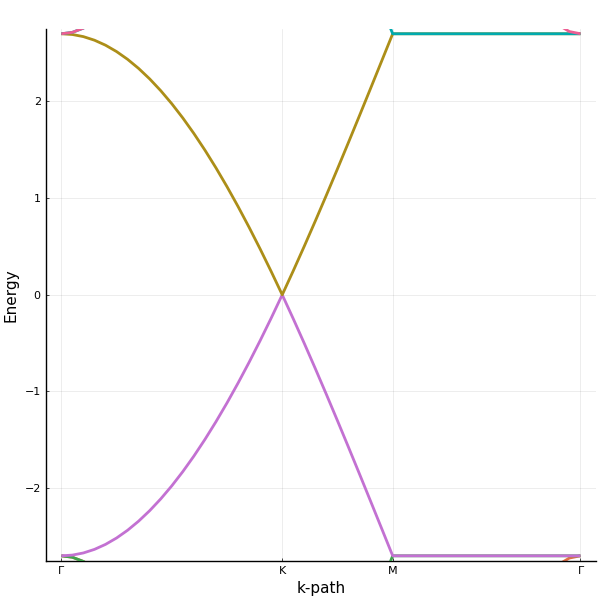

In [19]:
# phipath,pathticks = AuxFunctions.phipath_2D_GammaKMGamma();
phipath,pathticks = phipath_2D_GammaKMGamma();
En_phipath = AuxFunctions.En_phipath_2D(H2D,phipath);
MyPlots.Ebands(En_phipath,pathticks=pathticks)